# CDC Diabetes Dataset: Calibration ver

In this notebook the optimal Deferral Net configuration is chosen, and the deferral tau threshold is calibrated.

Following the BRIDGET experimental pipeline, the Deferral Net is trained on the data predicted by the Human-in-Command process, then subsequently tested on the validation data to produce the optimal Tau deferral coefficient.

The architecture for the Nets to be tested are [(16, 8), (32, 16)].

The optimizer used is ADAM

The dropout rate was set to 0.2 to ensure the nets dont overfit initially, then tested up to 0.5



### Libraries and functions

In [ ]:
# retrieving all libraries
%load_ext autoreload
%autoreload 2


from matplotlib import pyplot as plt

import os
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt



from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from river import rules, tree, datasets, drift, metrics, evaluate
from river import imblearn
from river import preprocessing
from river import metrics
from river import ensemble, linear_model, forest

from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from ignite.metrics import Accuracy, Loss
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint
from ignite.contrib.handlers import global_step_from_engine


from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper


from bridget_utils import *
from classes import BetaUser, DeferralNet, PyTorchWrapper, RiverModelWrapper
from bridget_mod import BRIDGET, HiC, MiC


26-Jan-27 15:52:45 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [2]:
def plot_confusion_matrix(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Indovinata', 'Pred Errata'], yticklabels=['Real Indovinata', 'Real Errata'])
    plt.xlabel('Predizione DeferralNet')
    plt.ylabel('Verità (Errore ARF)')
    plt.title('Confusion Matrix - DeferralNet')
    plt.show()
    
    print(classification_report(all_labels, all_preds))

## Expert: Accurate, Trusting

In [3]:
# retrieving the calibration split 

df_val= pd.read_csv(r".\processed_data\CDC_data\calibration_datasets\acc_t_calibration")
df_val= df_val.rename(columns={'Diabetes_binary': 'ground_truth'})  # per non confondermi
df_val.drop_duplicates()

,HvyAlcoholConsump,HighChol,Stroke,NoDocbcCost,Fruits,DiffWalk,Education,Veggies,Sex,Income,...,AnyHealthcare,HeartDiseaseorAttack,GenHlth,HighBP,Smoker,CholCheck,BMI,MentHlth,PhysHlth,ground_truth
0,0,1,0,1,1,1,6,1,0,5,...,1,1,4,1,0,1,0.0,0.0,0.0,1.0
1,0,0,1,0,1,0,6,1,1,7,...,1,0,3,0,1,1,0.0,0.0,0.0,1.0
2,0,0,0,0,0,1,4,0,0,3,...,0,0,4,1,1,1,0.0,0.0,0.0,1.0
3,0,1,0,0,1,0,6,1,0,5,...,1,0,3,1,1,1,0.0,0.0,0.0,0.0
4,0,0,1,0,0,1,5,1,0,7,...,1,1,3,0,0,1,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14133,0,0,0,1,1,0,6,1,0,6,...,1,0,2,0,1,1,0.0,0.0,0.0,0.0
14134,0,0,0,0,0,0,4,0,1,4,...,1,0,1,1,1,1,0.0,0.0,0.0,0.0
14135,1,1,0,0,1,0,6,1,1,1,...,1,0,2,1,0,1,0.0,0.0,0.0,0.0
14136,0,1,0,0,0,1,4,0,0,5,...,1,0,4,1,1,1,0.0,0.0,0.0,1.0


In [4]:
# retrieving data

df_acc_t = pd.read_csv(r".\processed_data\CDC_data\hic_results_ds\hic_accurate_trusting")

df_acc_t= df_acc_t.rename(columns={'Diabetes_binary':'g_truth'})  

df_acc_t.to_csv(r".\processed_data\CDC_data\switch_ds\acc_t_switch", index= False) # questa versione di df è quella che viene passata a start Mic come df switch



In [ ]:
feat_order = [c for c in df_acc_t.columns if c not in [
    'Diabetes_binary', 'g_truth', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]


X_cal = torch.tensor(df_acc_t[feat_order].values, dtype=torch.float32)
y_cal = torch.tensor(df_acc_t['g_truth'].values, dtype=torch.long)

acc_t_df = TensorDataset(X_cal, y_cal)
acc_t_loader = DataLoader(acc_t_df, batch_size=64, shuffle=False)

X_val = torch.tensor(df_val[feat_order].values, dtype=torch.float32)
y_val = torch.tensor(df_val['ground_truth'].values, dtype=torch.long)

val_d = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_d, batch_size=32, shuffle=False)

### Deferral Strat 1

#### Net 1: 16/8

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
## instantiating def net

small_net= DeferralNet(input_size= 21, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.4)

small_net.to(device)

optimizer = optim.Adam(params=small_net.parameters(), 
                       lr=0.0001,
                       weight_decay= 1e-3
                    )
criterion= nn.CrossEntropyLoss()


##### Training

In [8]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(small_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(acc_t_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\CDC_diabetes\acc_t_models',
    filename_prefix='16_8_acc_t',
    n_saved=1,
    create_dir=True,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': small_net})


trainer.run(acc_t_loader, max_epochs= 10)

Epoch[1], Iter[100] Loss: 0.68
Epoch[1], Iter[200] Loss: 0.66
Epoch[1], Iter[300] Loss: 0.64
Epoch[1], Iter[400] Loss: 0.68
Epoch[1], Iter[500] Loss: 0.62
Epoch[1], Iter[600] Loss: 0.61
Training Results - Epoch[1] Avg accuracy: 0.81 Avg loss: 0.59
Validation Results - Epoch[1] Avg accuracy: 0.69 Avg loss: 0.65
Epoch[2], Iter[700] Loss: 0.57
Epoch[2], Iter[800] Loss: 0.60
Epoch[2], Iter[900] Loss: 0.53
Epoch[2], Iter[1000] Loss: 0.59
Epoch[2], Iter[1100] Loss: 0.58
Epoch[2], Iter[1200] Loss: 0.56
Training Results - Epoch[2] Avg accuracy: 0.85 Avg loss: 0.43
Validation Results - Epoch[2] Avg accuracy: 0.71 Avg loss: 0.57
Epoch[3], Iter[1300] Loss: 0.44
Epoch[3], Iter[1400] Loss: 0.42
Epoch[3], Iter[1500] Loss: 0.47
Epoch[3], Iter[1600] Loss: 0.40
Epoch[3], Iter[1700] Loss: 0.44
Epoch[3], Iter[1800] Loss: 0.46
Epoch[3], Iter[1900] Loss: 0.56
Training Results - Epoch[3] Avg accuracy: 0.86 Avg loss: 0.37
Validation Results - Epoch[3] Avg accuracy: 0.72 Avg loss: 0.56
Epoch[4], Iter[2000] Lo

State:
	iteration: 6440
	epoch: 10
	epoch_length: 644
	max_epochs: 10
	output: 0.3225855231285095
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

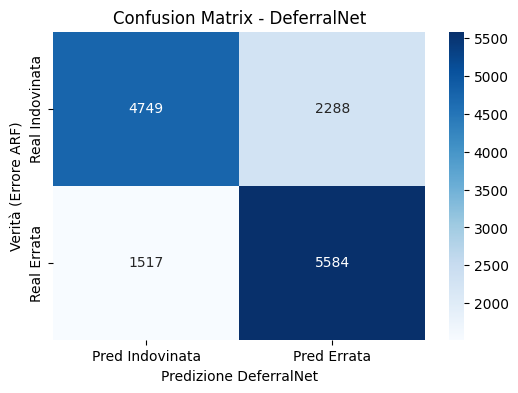

              precision    recall  f1-score   support

           0       0.76      0.67      0.71      7037
           1       0.71      0.79      0.75      7101

    accuracy                           0.73     14138
   macro avg       0.73      0.73      0.73     14138
weighted avg       0.73      0.73      0.73     14138



In [ ]:
plot_confusion_matrix(small_net, val_loader, device)

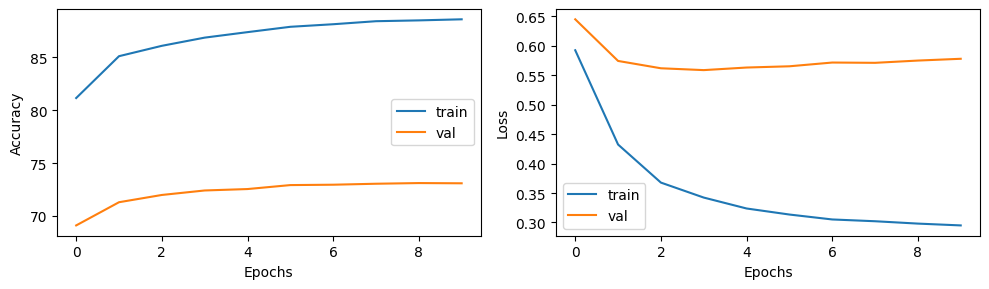

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

##### Tau Threshold

In [11]:
# dopo avere scelto la net migliore

probas= small_net.predict_proba_nn(X_val, device)
y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.8
0.8165898617511521


#### Net 2: 32/16

In [13]:
## instantiating the Deferral Net structures + Dropout rate 0.2 e Early Stopping

large_net= DeferralNet(input_size= 21, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
large_net.to(device)

optimizer = optim.Adam(params=large_net.parameters(), 
                       lr=0.0001,
                       weight_decay= 1e-3
                    )
criterion= nn.CrossEntropyLoss()


##### Training

Epoch[1], Iter[100] Loss: 0.66
Epoch[1], Iter[200] Loss: 0.62
Epoch[1], Iter[300] Loss: 0.69
Epoch[1], Iter[400] Loss: 0.61
Epoch[1], Iter[500] Loss: 0.58
Epoch[1], Iter[600] Loss: 0.49
Training Results - Epoch[1] Avg accuracy: 0.81 Avg loss: 0.48
Validation Results - Epoch[1] Avg accuracy: 0.69 Avg loss: 0.59
Epoch[2], Iter[700] Loss: 0.42
Epoch[2], Iter[800] Loss: 0.52
Epoch[2], Iter[900] Loss: 0.44
Epoch[2], Iter[1000] Loss: 0.48
Epoch[2], Iter[1100] Loss: 0.42
Epoch[2], Iter[1200] Loss: 0.46
Training Results - Epoch[2] Avg accuracy: 0.85 Avg loss: 0.38
Validation Results - Epoch[2] Avg accuracy: 0.71 Avg loss: 0.57
Epoch[3], Iter[1300] Loss: 0.38
Epoch[3], Iter[1400] Loss: 0.30
Epoch[3], Iter[1500] Loss: 0.44
Epoch[3], Iter[1600] Loss: 0.35
Epoch[3], Iter[1700] Loss: 0.27
Epoch[3], Iter[1800] Loss: 0.35
Epoch[3], Iter[1900] Loss: 0.45
Training Results - Epoch[3] Avg accuracy: 0.87 Avg loss: 0.33
Validation Results - Epoch[3] Avg accuracy: 0.72 Avg loss: 0.56
Epoch[4], Iter[2000] Lo

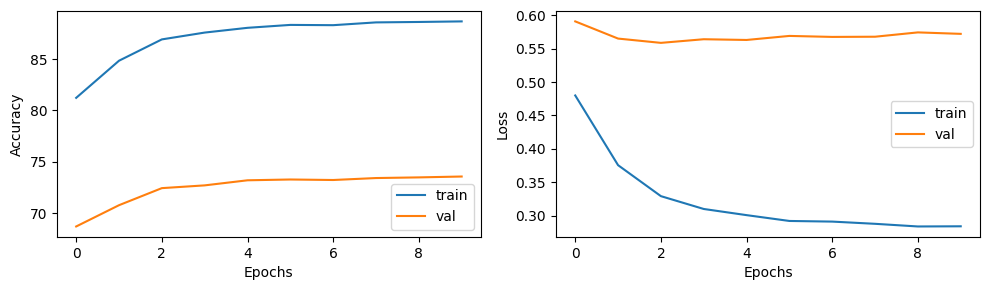

In [14]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(large_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(acc_t_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=50, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'nets\CDC_diabetes\acc_t_models',
    filename_prefix='32_16_acc_t',
    n_saved=1,
    create_dir=True,
    global_step_transform=global_step_from_engine(trainer), # helps fetch the trainer's state
    require_empty= False
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': large_net})


trainer.run(acc_t_loader, max_epochs= 10)



fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

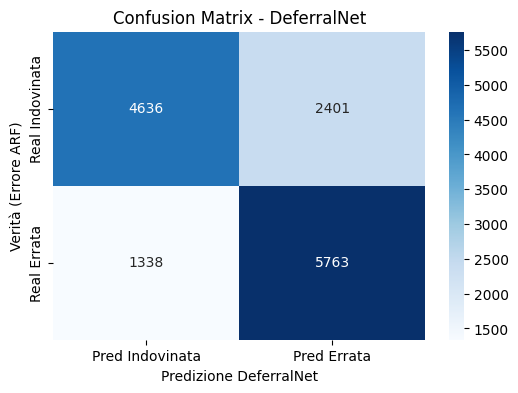

              precision    recall  f1-score   support

           0       0.78      0.66      0.71      7037
           1       0.71      0.81      0.76      7101

    accuracy                           0.74     14138
   macro avg       0.74      0.74      0.73     14138
weighted avg       0.74      0.74      0.73     14138



In [15]:
plot_confusion_matrix(large_net, val_loader, device)

##### Tau Threshold

In [16]:
# dopo avere scelto la net migliore

probas= large_net.predict_proba_nn(X_val, device)
y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.81
0.8172437514331575


### Deferral Strat 2 (anqi mao style) con la rete 1

In [18]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_acc_t.iterrows():

    x_i = row[feat_order].values.tolist()
    #x_i = list(entry['dict_form'].values())
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)

In [19]:
# sulla base di x_def chiamo la rete 

r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff= 0.3)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-3)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [20]:
save_dir = r'.\r_nets\CDC'
os.makedirs(save_dir, exist_ok=True)

r_net.to(device)
r_net.train()

for epoch in range(20):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/20 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_acc_t.pth'))
print("✅ r_net salvata correttamente in", save_dir)

Epoch 1/20 - Loss: 0.3453
Epoch 2/20 - Loss: 0.3236
Epoch 3/20 - Loss: 0.3171
Epoch 4/20 - Loss: 0.3132
Epoch 5/20 - Loss: 0.3111
Epoch 6/20 - Loss: 0.3099
Epoch 7/20 - Loss: 0.3090
Epoch 8/20 - Loss: 0.3085
Epoch 9/20 - Loss: 0.3081
Epoch 10/20 - Loss: 0.3079
Epoch 11/20 - Loss: 0.3079
Epoch 12/20 - Loss: 0.3078
Epoch 13/20 - Loss: 0.3077
Epoch 14/20 - Loss: 0.3076
Epoch 15/20 - Loss: 0.3076
Epoch 16/20 - Loss: 0.3076
Epoch 17/20 - Loss: 0.3075
Epoch 18/20 - Loss: 0.3075
Epoch 19/20 - Loss: 0.3076
Epoch 20/20 - Loss: 0.3075
✅ r_net salvata correttamente in .\r_nets\CDC


In [21]:
p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

#richiamo la net 
small_net= DeferralNet(input_size= 21, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.4)

net_path= r".\nets\CDC_diabetes\acc_t_models\16_8_acc_t_model_10.pt"
small_net.load_state_dict(torch.load(net_path, map_location=device))
small_net.to(device)

y_h_calib = small_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.1, 0.9, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.100000       0.999976       0.973772
1   0.116327       0.998520       0.761228
2   0.132653       0.978551       0.388718
3   0.148980       0.888851       0.010579
4   0.165306       0.885940       0.000121
5   0.181633       0.885891       0.000000
6   0.197959       0.885891       0.000000
7   0.214286       0.885891       0.000000
8   0.230612       0.885891       0.000000
9   0.246939       0.885891       0.000000
10  0.263265       0.885891       0.000000
11  0.279592       0.885891       0.000000
12  0.295918       0.885891       0.000000
13  0.312245       0.885891       0.000000
14  0.328571       0.885891       0.000000
15  0.344898       0.885891       0.000000
16  0.361224       0.885891       0.000000
17  0.377551       0.885891       0.000000
18  0.393878       0.885891       0.000000
19  0.410204       0.885891       0.000000
20  0.426531       0.885891       0.000000
21  0.442857       0.885891       0.000000
22  0.45918

## Expert: Inaccurate, Trusting

In [22]:
# retrieving the calibration split 

df_val= pd.read_csv(r".\processed_data\CDC_data\calibration_datasets\inacc_t_calibration")
df_val= df_val.rename(columns={'Diabetes_binary': 'ground_truth'})  # per non confondermi
df_val.drop_duplicates()

,HvyAlcoholConsump,HighChol,Stroke,NoDocbcCost,Fruits,DiffWalk,Education,Veggies,Sex,Income,...,AnyHealthcare,HeartDiseaseorAttack,GenHlth,HighBP,Smoker,CholCheck,BMI,MentHlth,PhysHlth,ground_truth
0,0,1,0,1,1,1,6,1,0,5,...,1,1,4,1,0,1,2.434639,-0.456604,0.358297,1.0
1,0,0,1,0,1,0,6,1,1,7,...,1,0,3,0,1,1,0.367257,-0.456604,-0.119170,1.0
2,0,0,0,0,0,1,4,0,0,3,...,0,0,4,1,1,1,0.810268,-0.456604,2.268163,1.0
3,0,1,0,0,1,0,6,1,0,5,...,1,0,3,1,1,1,-0.814104,-0.092014,-0.405650,0.0
4,0,0,1,0,0,1,5,1,0,7,...,1,1,3,0,0,1,-0.518764,-0.456604,-0.596636,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14133,0,0,0,1,1,0,6,1,0,6,...,1,0,2,0,1,1,-1.109444,-0.092014,-0.405650,0.0
14134,0,0,0,0,0,0,4,0,1,4,...,1,0,1,1,1,1,-0.371093,-0.456604,-0.596636,0.0
14135,1,1,0,0,1,0,6,1,1,1,...,1,0,2,1,0,1,-0.075753,-0.456604,-0.596636,0.0
14136,0,1,0,0,0,1,4,0,0,5,...,1,0,4,1,1,1,1.253278,-0.456604,1.313230,1.0


In [23]:
# dropping irrelevant feat + renaming the decision column as 'ground truth' 
df_inacc_t= pd.read_csv(r".\processed_data\CDC_data\hic_results_ds\hic_inaccurate_trusting")

df_inacc_t= df_inacc_t.rename(columns={'Diabetes_binary':'g_truth'})  

df_inacc_t.to_csv(r".\processed_data\CDC_data\switch_ds\inacc_t_switch", index= False) # questa versione di df è quella che viene passata a start Mic come df switch


In [ ]:

feat_order = [c for c in df_inacc_t.columns if c not in [
    'Diabetes_binary', 'g_truth', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]

X_cal = torch.tensor(df_inacc_t[feat_order].values, dtype=torch.float32)
y_cal = torch.tensor(df_inacc_t['g_truth'].values, dtype=torch.long)

inacc_t_df = TensorDataset(X_cal, y_cal)
inacc_t_loader = DataLoader(inacc_t_df, batch_size=64, shuffle=False)

X_val = torch.tensor(df_val[feat_order].values, dtype=torch.float32)
y_val = torch.tensor(df_val['ground_truth'].values, dtype=torch.long)

val_d = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_d, batch_size=32, shuffle=False)

#### Net 1

In [25]:
## instantiating the Deferral Net structures + Dropout rate 0.2 e Early Stopping

small_net= DeferralNet(input_size= 21, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.5)
optimizer = optim.Adam(params=small_net.parameters(), 
                       lr=0.0001,
                       weight_decay= 1e-2
                    )
criterion= nn.CrossEntropyLoss()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
small_net.to(device)

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=21, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

##### Training

In [26]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(small_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(inacc_t_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=45, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\CDC_diabetes\inacc_t_models',
    filename_prefix='16_8',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': small_net})


trainer.run(inacc_t_loader, max_epochs= 10)

Epoch[1], Iter[100] Loss: 0.77
Epoch[1], Iter[200] Loss: 0.68
Epoch[1], Iter[300] Loss: 0.71
Epoch[1], Iter[400] Loss: 0.66
Epoch[1], Iter[500] Loss: 0.68
Epoch[1], Iter[600] Loss: 0.72
Training Results - Epoch[1] Avg accuracy: 0.81 Avg loss: 0.65
Validation Results - Epoch[1] Avg accuracy: 0.72 Avg loss: 0.66
Epoch[2], Iter[700] Loss: 0.63
Epoch[2], Iter[800] Loss: 0.67
Epoch[2], Iter[900] Loss: 0.57
Epoch[2], Iter[1000] Loss: 0.62
Epoch[2], Iter[1100] Loss: 0.59
Epoch[2], Iter[1200] Loss: 0.62
Training Results - Epoch[2] Avg accuracy: 0.84 Avg loss: 0.57
Validation Results - Epoch[2] Avg accuracy: 0.72 Avg loss: 0.61
Epoch[3], Iter[1300] Loss: 0.54
Epoch[3], Iter[1400] Loss: 0.57
Epoch[3], Iter[1500] Loss: 0.62
Epoch[3], Iter[1600] Loss: 0.59
Epoch[3], Iter[1700] Loss: 0.61
Epoch[3], Iter[1800] Loss: 0.54
Epoch[3], Iter[1900] Loss: 0.60
Training Results - Epoch[3] Avg accuracy: 0.84 Avg loss: 0.49
Validation Results - Epoch[3] Avg accuracy: 0.72 Avg loss: 0.58
Epoch[4], Iter[2000] Lo

State:
	iteration: 6440
	epoch: 10
	epoch_length: 644
	max_epochs: 10
	output: 0.5199518203735352
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

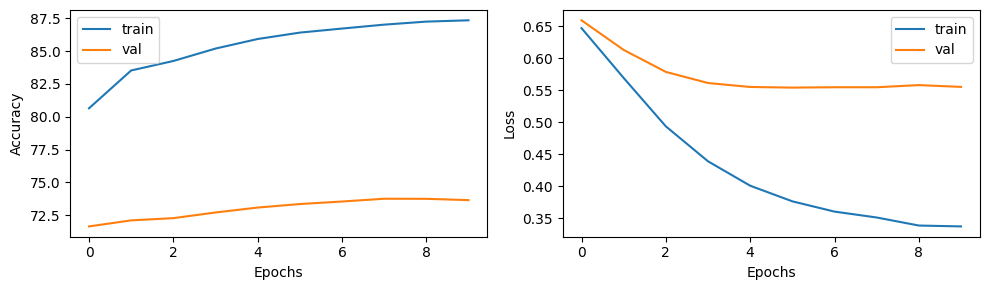

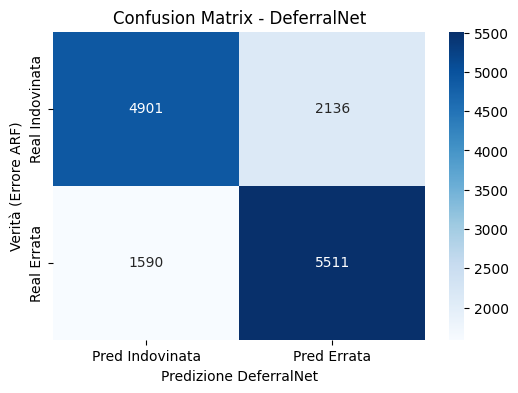

              precision    recall  f1-score   support

           0       0.76      0.70      0.72      7037
           1       0.72      0.78      0.75      7101

    accuracy                           0.74     14138
   macro avg       0.74      0.74      0.74     14138
weighted avg       0.74      0.74      0.74     14138



In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)

##### Tau Threshold

In [28]:
# dopo avere scelto la net migliore

probas= small_net.predict_proba_nn(X_val, device)
y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.77
0.8222860425043079


#### Net 2: 32/16

In [30]:
## instantiating the Deferral Net structures + Dropout rate 0.2 e Early Stopping

large_net= DeferralNet(input_size= 21, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.4)

optimizer= optim.Adam(large_net.parameters(), lr=0.0001, weight_decay=1e-2)
criterion= nn.CrossEntropyLoss()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
large_net.to(device)

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=21, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Training

Epoch[1], Iter[100] Loss: 0.67
Epoch[1], Iter[200] Loss: 0.67
Epoch[1], Iter[300] Loss: 0.65
Epoch[1], Iter[400] Loss: 0.66
Epoch[1], Iter[500] Loss: 0.63
Epoch[1], Iter[600] Loss: 0.65
Training Results - Epoch[1] Avg accuracy: 0.79 Avg loss: 0.61
Validation Results - Epoch[1] Avg accuracy: 0.69 Avg loss: 0.64
Epoch[2], Iter[700] Loss: 0.62
Epoch[2], Iter[800] Loss: 0.53
Epoch[2], Iter[900] Loss: 0.56
Epoch[2], Iter[1000] Loss: 0.61
Epoch[2], Iter[1100] Loss: 0.49
Epoch[2], Iter[1200] Loss: 0.54
Training Results - Epoch[2] Avg accuracy: 0.83 Avg loss: 0.44
Validation Results - Epoch[2] Avg accuracy: 0.71 Avg loss: 0.56
Epoch[3], Iter[1300] Loss: 0.43
Epoch[3], Iter[1400] Loss: 0.34
Epoch[3], Iter[1500] Loss: 0.45
Epoch[3], Iter[1600] Loss: 0.43
Epoch[3], Iter[1700] Loss: 0.42
Epoch[3], Iter[1800] Loss: 0.39
Epoch[3], Iter[1900] Loss: 0.48
Training Results - Epoch[3] Avg accuracy: 0.85 Avg loss: 0.36
Validation Results - Epoch[3] Avg accuracy: 0.73 Avg loss: 0.55
Epoch[4], Iter[2000] Lo

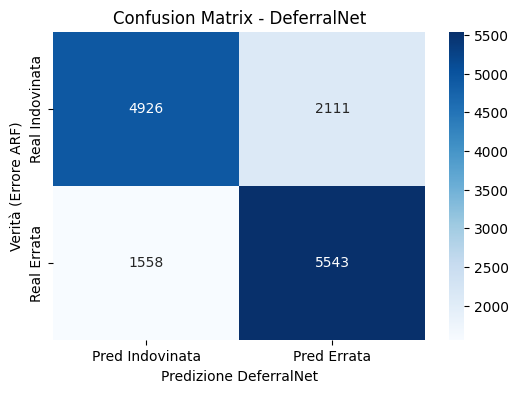

              precision    recall  f1-score   support

           0       0.76      0.70      0.73      7037
           1       0.72      0.78      0.75      7101

    accuracy                           0.74     14138
   macro avg       0.74      0.74      0.74     14138
weighted avg       0.74      0.74      0.74     14138



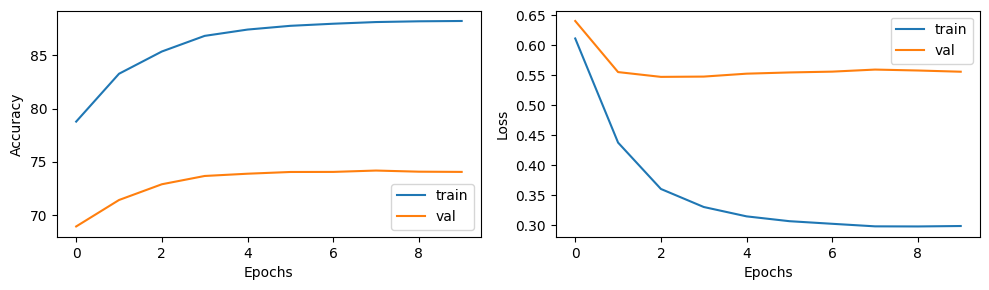

In [31]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(large_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(inacc_t_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=50, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\inacc_t_models',
    filename_prefix='32_16',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': large_net})


trainer.run(inacc_t_loader, max_epochs= 10)

plot_confusion_matrix(large_net, val_loader, device)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

##### Tau Threshold

In [32]:
# dopo avere scelto la net migliore

probas= small_net.predict_proba_nn(X_val, device)
y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.77
0.8222860425043079


### Deferral Strat 2 (anqi mao style)

In [34]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_inacc_t.iterrows():

    x_i = row[feat_order].values.tolist()
    #x_i = list(entry['dict_form'].values())
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)


In [35]:
# sulla base di x_def chiamo la rete 

r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff= 0.3)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-3)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
r_net.to(device)
r_net.train()

for epoch in range(20):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/20 - Loss: {running_loss/len(loader):.4f}")

torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_inacc_t.pth'))
print("✅ r_net salvata correttamente in", save_dir)

p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

Epoch 1/20 - Loss: 0.3384
Epoch 2/20 - Loss: 0.3201
Epoch 3/20 - Loss: 0.3144
Epoch 4/20 - Loss: 0.3109
Epoch 5/20 - Loss: 0.3092
Epoch 6/20 - Loss: 0.3081
Epoch 7/20 - Loss: 0.3075
Epoch 8/20 - Loss: 0.3071
Epoch 9/20 - Loss: 0.3068
Epoch 10/20 - Loss: 0.3067
Epoch 11/20 - Loss: 0.3066
Epoch 12/20 - Loss: 0.3065
Epoch 13/20 - Loss: 0.3064
Epoch 14/20 - Loss: 0.3063
Epoch 15/20 - Loss: 0.3063
Epoch 16/20 - Loss: 0.3063
Epoch 17/20 - Loss: 0.3063
Epoch 18/20 - Loss: 0.3063
Epoch 19/20 - Loss: 0.3062
Epoch 20/20 - Loss: 0.3063
✅ r_net salvata correttamente in .\r_nets\CDC


In [36]:
#richiamo la net 
small_net= DeferralNet(input_size= 21, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.4)

net_path= r".\nets\CDC_diabetes\inacc_t_models\16_8_model_10.pt"
small_net.load_state_dict(torch.load(net_path, map_location=device))
small_net.to(device)

y_h_calib = small_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.0, 1.0, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.000000       1.000000       1.000000
1   0.020408       1.000000       1.000000
2   0.040816       1.000000       1.000000
3   0.061224       1.000000       1.000000
4   0.081633       1.000000       1.000000
5   0.102041       0.999927       0.945942
6   0.122449       0.990052       0.504404
7   0.142857       0.925318       0.144874
8   0.163265       0.873396       0.000000
9   0.183673       0.873396       0.000000
10  0.204082       0.873396       0.000000
11  0.224490       0.873396       0.000000
12  0.244898       0.873396       0.000000
13  0.265306       0.873396       0.000000
14  0.285714       0.873396       0.000000
15  0.306122       0.873396       0.000000
16  0.326531       0.873396       0.000000
17  0.346939       0.873396       0.000000
18  0.367347       0.873396       0.000000
19  0.387755       0.873396       0.000000
20  0.408163       0.873396       0.000000
21  0.428571       0.873396       0.000000
22  0.44898

## Expert: Accurate, Not Trusting

In [37]:
# retrieving the calibration split 

df_val= pd.read_csv(r".\processed_data\CDC_data\calibration_datasets\acc_nt_calibration")
df_val= df_val.rename(columns={'Diabetes_binary': 'ground_truth'})  # per non confondermi
df_val.drop_duplicates()

,Education,Sex,Veggies,NoDocbcCost,CholCheck,GenHlth,HvyAlcoholConsump,Income,Age,HeartDiseaseorAttack,...,HighBP,DiffWalk,PhysActivity,HighChol,Fruits,Smoker,BMI,MentHlth,PhysHlth,ground_truth
0,6,0,1,1,1,4,0,5,9,1,...,1,1,1,1,1,0,0.0,0.0,0.0,1.0
1,6,1,1,0,1,3,0,7,10,0,...,0,0,1,0,1,1,0.0,0.0,0.0,1.0
2,4,0,0,0,1,4,0,3,10,0,...,1,1,0,0,0,1,0.0,0.0,0.0,1.0
3,6,0,1,0,1,3,0,5,12,0,...,1,0,0,1,1,1,0.0,0.0,0.0,0.0
4,5,0,1,0,1,3,0,7,13,1,...,0,1,0,0,0,0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14133,6,0,1,1,1,2,0,6,8,0,...,0,0,1,0,1,1,0.0,0.0,0.0,0.0
14134,4,1,0,0,1,1,0,4,12,0,...,1,0,1,0,0,1,0.0,0.0,0.0,0.0
14135,6,1,1,0,1,2,1,1,3,0,...,1,0,1,1,1,0,0.0,0.0,0.0,0.0
14136,4,0,0,0,1,4,0,5,12,0,...,1,1,0,1,0,1,0.0,0.0,0.0,1.0


In [ ]:
# retrieving data

df_acc_nt = pd.read_csv(r".\processed_data\CDC_data\hic_results_ds\hic_accurate_not_trusting")


df_acc_nt= df_acc_nt.rename(columns={'Diabetes_binary':'g_truth'})  

df_acc_nt.to_csv(r".\processed_data\CDC_data\switch_ds\acc_nt_switch", index= False) # questa versione di df è quella che viene passata a start Mic come df switch
df_acc_nt


,Education,Sex,Veggies,NoDocbcCost,CholCheck,GenHlth,HvyAlcoholConsump,Income,Age,HeartDiseaseorAttack,...,Smoker,BMI,MentHlth,PhysHlth,expert prediction,machine prediction,ground truth,proba_model,g_truth,provider
0,6,0,1,0,1,2,0,8,11,0,...,0,0.104175,-0.444360,-0.589540,0,0,0,0.585667,0,H
1,6,0,0,0,1,2,0,8,10,0,...,0,-0.509814,-0.444094,-0.589144,0,0,0,0.676193,0,H
2,4,0,0,0,1,2,0,5,11,0,...,0,-0.048887,-0.443829,-0.588748,0,1,0,0.510580,0,H
3,4,0,0,0,1,3,0,5,10,0,...,1,-0.509699,-0.443565,-0.588353,0,0,0,0.675843,0,H
4,4,1,1,0,1,4,0,2,7,0,...,0,-0.816555,3.176168,0.103983,0,1,0,0.674826,1,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41210,6,1,0,0,1,3,0,6,11,0,...,1,0.306964,0.147240,-0.480874,1,1,1,0.642414,1,H
41211,4,0,1,1,1,3,0,2,4,0,...,1,1.293362,1.366678,-0.579989,1,1,1,0.660942,1,H
41212,6,1,1,0,1,3,0,8,5,0,...,0,0.306927,-0.462523,-0.282612,0,0,0,0.504624,0,H
41213,5,0,1,0,1,4,0,6,9,0,...,0,-0.115832,0.147217,0.906871,1,1,1,0.705318,1,H


In [ ]:
feat_order = [c for c in df_acc_nt.columns if c not in [
    'Diabetes_binary', 'g_truth', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]

X_cal = torch.tensor(df_acc_nt[feat_order].values, dtype=torch.float32)
y_cal = torch.tensor(df_acc_nt['g_truth'].values, dtype=torch.long)

acc_nt_df = TensorDataset(X_cal, y_cal)
acc_nt_loader = DataLoader(acc_nt_df, batch_size=64, shuffle=False)

X_val = torch.tensor(df_val[feat_order].values, dtype=torch.float32)
y_val = torch.tensor(df_val['ground_truth'].values, dtype=torch.long)

val_d = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_d, batch_size=32, shuffle=False)

### Confidence Based Deferral

#### Net 1 16/8

In [ ]:
small_net= DeferralNet(input_size= 21, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.5)
optimizer= optim.Adam(small_net.parameters(), lr=0.0001, weight_decay=1e-2)
criterion= nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
small_net.to(device)

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=21, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

##### Training

In [41]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(small_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(acc_nt_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=50, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\CDC_diabetes\acc_nt_models',
    filename_prefix='16_8_acc_nt',
    n_saved=1,
    create_dir=True,
    require_empty= False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': small_net})


trainer.run(acc_nt_loader, max_epochs= 10)

Epoch[1], Iter[100] Loss: 0.70
Epoch[1], Iter[200] Loss: 0.68
Epoch[1], Iter[300] Loss: 0.68
Epoch[1], Iter[400] Loss: 0.74
Epoch[1], Iter[500] Loss: 0.71
Epoch[1], Iter[600] Loss: 0.64
Training Results - Epoch[1] Avg accuracy: 0.52 Avg loss: 0.66
Validation Results - Epoch[1] Avg accuracy: 0.50 Avg loss: 0.69
Epoch[2], Iter[700] Loss: 0.68
Epoch[2], Iter[800] Loss: 0.66
Epoch[2], Iter[900] Loss: 0.67
Epoch[2], Iter[1000] Loss: 0.65
Epoch[2], Iter[1100] Loss: 0.65
Epoch[2], Iter[1200] Loss: 0.66
Training Results - Epoch[2] Avg accuracy: 0.77 Avg loss: 0.58
Validation Results - Epoch[2] Avg accuracy: 0.66 Avg loss: 0.64
Epoch[3], Iter[1300] Loss: 0.59
Epoch[3], Iter[1400] Loss: 0.55
Epoch[3], Iter[1500] Loss: 0.68
Epoch[3], Iter[1600] Loss: 0.57
Epoch[3], Iter[1700] Loss: 0.63
Epoch[3], Iter[1800] Loss: 0.58
Epoch[3], Iter[1900] Loss: 0.69
Training Results - Epoch[3] Avg accuracy: 0.83 Avg loss: 0.50
Validation Results - Epoch[3] Avg accuracy: 0.70 Avg loss: 0.61
Epoch[4], Iter[2000] Lo

State:
	iteration: 6440
	epoch: 10
	epoch_length: 644
	max_epochs: 10
	output: 0.437897264957428
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

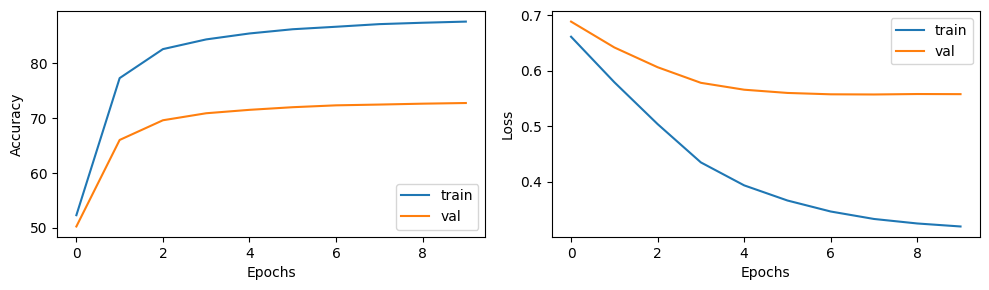

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

##### Tau Threshold

In [43]:
# dopo avere scelto la net migliore

probas= small_net.predict_proba_nn(X_val, device)
y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.77
0.80758411162372


#### Net 2 32/16

In [ ]:

large_net= DeferralNet(input_size= 21, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.5)

optimizer= optim.Adam(large_net.parameters(), lr=0.0001, weight_decay=1e-2)
criterion= nn.CrossEntropyLoss()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
large_net.to(device)

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=21, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Training

Epoch[1], Iter[100] Loss: 0.76
Epoch[1], Iter[200] Loss: 0.66
Epoch[1], Iter[300] Loss: 0.70
Epoch[1], Iter[400] Loss: 0.70
Epoch[1], Iter[500] Loss: 0.63
Epoch[1], Iter[600] Loss: 0.60
Training Results - Epoch[1] Avg accuracy: 0.81 Avg loss: 0.61
Validation Results - Epoch[1] Avg accuracy: 0.69 Avg loss: 0.64
Epoch[2], Iter[700] Loss: 0.58
Epoch[2], Iter[800] Loss: 0.58
Epoch[2], Iter[900] Loss: 0.54
Epoch[2], Iter[1000] Loss: 0.55
Epoch[2], Iter[1100] Loss: 0.61
Epoch[2], Iter[1200] Loss: 0.54
Training Results - Epoch[2] Avg accuracy: 0.83 Avg loss: 0.45
Validation Results - Epoch[2] Avg accuracy: 0.71 Avg loss: 0.57
Epoch[3], Iter[1300] Loss: 0.46
Epoch[3], Iter[1400] Loss: 0.35
Epoch[3], Iter[1500] Loss: 0.45
Epoch[3], Iter[1600] Loss: 0.47
Epoch[3], Iter[1700] Loss: 0.48
Epoch[3], Iter[1800] Loss: 0.50
Epoch[3], Iter[1900] Loss: 0.46
Training Results - Epoch[3] Avg accuracy: 0.85 Avg loss: 0.38
Validation Results - Epoch[3] Avg accuracy: 0.72 Avg loss: 0.56
Epoch[4], Iter[2000] Lo

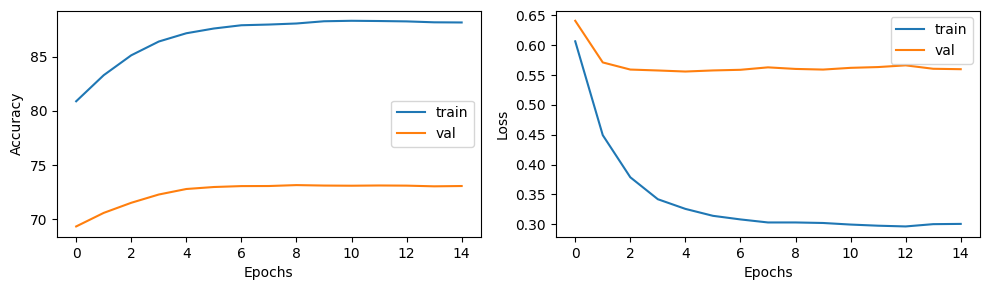

In [46]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(large_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(acc_nt_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=50, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\CDC_diabetes\acc_nt_models',
    filename_prefix='32_16_acc_nt',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': large_net})


trainer.run(acc_nt_loader, max_epochs= 15)



fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

##### Tau Threshold

In [47]:
# dopo avere scelto la net migliore

probas= large_net.predict_proba_nn(X_val, device)
y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.79
0.8203226186271046


### Anqi Mao style Deferral

In [49]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_acc_nt.iterrows():

    x_i = row[feat_order].values.tolist()
    
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)


In [ ]:
# sulla base di x_def chiamo la rete 

r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff= 0.5)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-3)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
r_net.to(device)
r_net.train()

for epoch in range(20):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) 
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/20 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_acc_nt.pth'))
print("✅ r_net salvata correttamente in", save_dir)

p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

Epoch 1/20 - Loss: 0.3755
Epoch 2/20 - Loss: 0.3318
Epoch 3/20 - Loss: 0.3215
Epoch 4/20 - Loss: 0.3158
Epoch 5/20 - Loss: 0.3125
Epoch 6/20 - Loss: 0.3107
Epoch 7/20 - Loss: 0.3097
Epoch 8/20 - Loss: 0.3093
Epoch 9/20 - Loss: 0.3089
Epoch 10/20 - Loss: 0.3090
Epoch 11/20 - Loss: 0.3089
Epoch 12/20 - Loss: 0.3089
Epoch 13/20 - Loss: 0.3089
Epoch 14/20 - Loss: 0.3088
Epoch 15/20 - Loss: 0.3088
Epoch 16/20 - Loss: 0.3089
Epoch 17/20 - Loss: 0.3088
Epoch 18/20 - Loss: 0.3087
Epoch 19/20 - Loss: 0.3087
Epoch 20/20 - Loss: 0.3087
✅ r_net salvata correttamente in .\r_nets\CDC


In [51]:
#richiamo la net 
small_net= DeferralNet(input_size= 21, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.5)

net_path= r".\nets\CDC_diabetes\inacc_t_models\16_8_model_10.pt"
small_net.load_state_dict(torch.load(net_path, map_location=device))
small_net.to(device)

y_h_calib = small_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.1, 0.5, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.100000       1.000000       0.997113
1   0.108163       0.999903       0.956472
2   0.116327       0.997598       0.812132
3   0.124490       0.917239       0.470751
4   0.132653       0.819168       0.277860
5   0.140816       0.680602       0.000194
6   0.148980       0.680529       0.000000
7   0.157143       0.680529       0.000000
8   0.165306       0.680529       0.000000
9   0.173469       0.680529       0.000000
10  0.181633       0.680529       0.000000
11  0.189796       0.680529       0.000000
12  0.197959       0.680529       0.000000
13  0.206122       0.680529       0.000000
14  0.214286       0.680529       0.000000
15  0.222449       0.680529       0.000000
16  0.230612       0.680529       0.000000
17  0.238776       0.680529       0.000000
18  0.246939       0.680529       0.000000
19  0.255102       0.680529       0.000000
20  0.263265       0.680529       0.000000
21  0.271429       0.680529       0.000000
22  0.27959

## Expert: Inaccurate, Not Trusting

In [52]:
# retrieving data

df_inacc_nt = pd.read_csv(r".\processed_data\CDC_data\hic_results_ds\hic_inaccurate_not_trusting")
df_inacc_nt.head(n=5)

df_inacc_nt= df_inacc_nt.rename(columns={'Diabetes_binary':'g_truth'})  

df_inacc_nt.to_csv(r".\processed_data\CDC_data\switch_ds\inacc_nt_switch", index= False) # questa versione di df è quella che viene passata a start Mic come df switch



In [ ]:
feat_order = [c for c in df_inacc_nt.columns if c not in [
    'Diabetes_binary', 'g_truth', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]


X_cal = torch.tensor(df_inacc_nt[feat_order].values, dtype=torch.float32)
y_cal = torch.tensor(df_inacc_nt['g_truth'].values, dtype=torch.long)

inacc_nt_df = TensorDataset(X_cal, y_cal)
inacc_nt_loader = DataLoader(inacc_nt_df, batch_size=64, shuffle=False)


X_val = torch.tensor(df_val[feat_order].values, dtype=torch.float32)
y_val = torch.tensor(df_val['ground_truth'].values, dtype=torch.long)

val_d = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_d, batch_size=32, shuffle=False)

### Deferral Strat 1

#### Net 1

In [ ]:

small_net= DeferralNet(input_size= 21, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.4)
optimizer= optim.Adam(small_net.parameters(), lr=0.0001, weight_decay=1e-3)
criterion= nn.CrossEntropyLoss()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
small_net.to(device)

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=21, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

##### Training

In [55]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(small_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(inacc_nt_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=50, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\CDC_diabetes\inacc_nt_models',
    filename_prefix='16_8_inacc_nt',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': small_net})


trainer.run(inacc_nt_loader, max_epochs= 10)

Epoch[1], Iter[100] Loss: 0.67
Epoch[1], Iter[200] Loss: 0.68
Epoch[1], Iter[300] Loss: 0.67
Epoch[1], Iter[400] Loss: 0.66
Epoch[1], Iter[500] Loss: 0.66
Epoch[1], Iter[600] Loss: 0.67
Training Results - Epoch[1] Avg accuracy: 0.78 Avg loss: 0.63
Validation Results - Epoch[1] Avg accuracy: 0.68 Avg loss: 0.66
Epoch[2], Iter[700] Loss: 0.59
Epoch[2], Iter[800] Loss: 0.61
Epoch[2], Iter[900] Loss: 0.61
Epoch[2], Iter[1000] Loss: 0.56
Epoch[2], Iter[1100] Loss: 0.57
Epoch[2], Iter[1200] Loss: 0.66
Training Results - Epoch[2] Avg accuracy: 0.82 Avg loss: 0.50
Validation Results - Epoch[2] Avg accuracy: 0.70 Avg loss: 0.60
Epoch[3], Iter[1300] Loss: 0.52
Epoch[3], Iter[1400] Loss: 0.45
Epoch[3], Iter[1500] Loss: 0.50
Epoch[3], Iter[1600] Loss: 0.52
Epoch[3], Iter[1700] Loss: 0.54
Epoch[3], Iter[1800] Loss: 0.48
Epoch[3], Iter[1900] Loss: 0.53
Training Results - Epoch[3] Avg accuracy: 0.85 Avg loss: 0.40
Validation Results - Epoch[3] Avg accuracy: 0.71 Avg loss: 0.57
Epoch[4], Iter[2000] Lo

State:
	iteration: 6440
	epoch: 10
	epoch_length: 644
	max_epochs: 10
	output: 0.45674198865890503
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

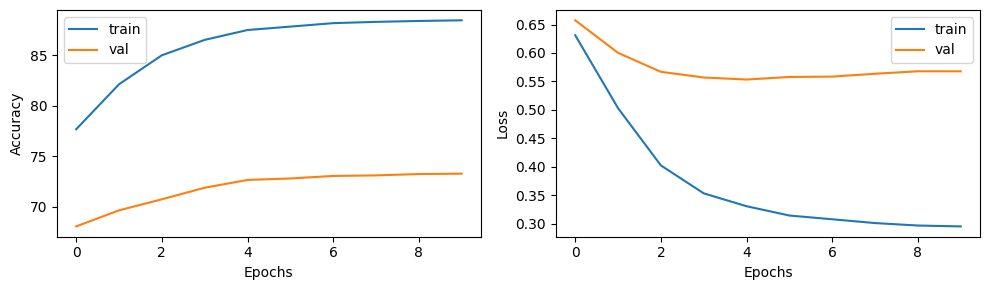

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

##### Tau Threshold

In [57]:
# dopo avere scelto la net migliore

probas= small_net.predict_proba_nn(X_val, device)
y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.79
0.8150408844869285


#### Net 2

In [59]:
## instantiating the Deferral Net structures + Dropout rate 0.2 e Early Stopping

large_net= DeferralNet(input_size= 21, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.4)

optimizer= optim.Adam(large_net.parameters(), lr=0.0001, weight_decay=1e-2)
criterion= nn.CrossEntropyLoss()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
large_net.to(device)

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=21, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Training

Epoch[1], Iter[100] Loss: 0.66
Epoch[1], Iter[200] Loss: 0.67
Epoch[1], Iter[300] Loss: 0.67
Epoch[1], Iter[400] Loss: 0.64
Epoch[1], Iter[500] Loss: 0.56
Epoch[1], Iter[600] Loss: 0.54
Training Results - Epoch[1] Avg accuracy: 0.79 Avg loss: 0.57
Validation Results - Epoch[1] Avg accuracy: 0.68 Avg loss: 0.63
Epoch[2], Iter[700] Loss: 0.56
Epoch[2], Iter[800] Loss: 0.58
Epoch[2], Iter[900] Loss: 0.55
Epoch[2], Iter[1000] Loss: 0.60
Epoch[2], Iter[1100] Loss: 0.48
Epoch[2], Iter[1200] Loss: 0.56
Training Results - Epoch[2] Avg accuracy: 0.83 Avg loss: 0.42
Validation Results - Epoch[2] Avg accuracy: 0.70 Avg loss: 0.57
Epoch[3], Iter[1300] Loss: 0.42
Epoch[3], Iter[1400] Loss: 0.37
Epoch[3], Iter[1500] Loss: 0.43
Epoch[3], Iter[1600] Loss: 0.37
Epoch[3], Iter[1700] Loss: 0.41
Epoch[3], Iter[1800] Loss: 0.44
Epoch[3], Iter[1900] Loss: 0.49
Training Results - Epoch[3] Avg accuracy: 0.85 Avg loss: 0.36
Validation Results - Epoch[3] Avg accuracy: 0.71 Avg loss: 0.56
Epoch[4], Iter[2000] Lo

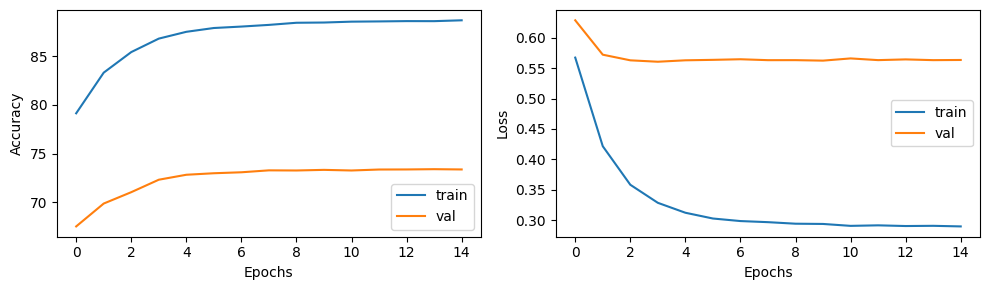

In [60]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(large_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(inacc_nt_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=50, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\CDC_diabetes\inacc_nt_models',
    filename_prefix='32_16_inacc_nt',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': large_net})


trainer.run(inacc_nt_loader, max_epochs= 15)



fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

##### Tau Threshold

In [61]:
# dopo avere scelto la net migliore

probas= large_net.predict_proba_nn(X_val, device)
y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.8
0.8169770364446476


### Anqi Mao Strat

In [63]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_inacc_nt.iterrows():

    x_i = row[feat_order].values.tolist()
    
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)



In [64]:
# sulla base di x_def chiamo la rete 

r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff= 0.5)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-3)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
r_net.to(device)
r_net.train()

for epoch in range(20):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/20 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_inacc_nt.pth'))
print("✅ r_net salvata correttamente in", save_dir)
p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()


Epoch 1/20 - Loss: 0.3439
Epoch 2/20 - Loss: 0.3213
Epoch 3/20 - Loss: 0.3150
Epoch 4/20 - Loss: 0.3128
Epoch 5/20 - Loss: 0.3111
Epoch 6/20 - Loss: 0.3103
Epoch 7/20 - Loss: 0.3098
Epoch 8/20 - Loss: 0.3095
Epoch 9/20 - Loss: 0.3095
Epoch 10/20 - Loss: 0.3093
Epoch 11/20 - Loss: 0.3093
Epoch 12/20 - Loss: 0.3092
Epoch 13/20 - Loss: 0.3092
Epoch 14/20 - Loss: 0.3092
Epoch 15/20 - Loss: 0.3092
Epoch 16/20 - Loss: 0.3092
Epoch 17/20 - Loss: 0.3091
Epoch 18/20 - Loss: 0.3092
Epoch 19/20 - Loss: 0.3092
Epoch 20/20 - Loss: 0.3091
✅ r_net salvata correttamente in .\r_nets\CDC


In [65]:
#richiamo la net 
small_net= DeferralNet(input_size= 21, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.5)

net_path= r".\nets\CDC_diabetes\inacc_t_models\16_8_model_10.pt"
small_net.load_state_dict(torch.load(net_path, map_location=device))
small_net.to(device)

y_h_calib = small_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.0, 0.5, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.000000       1.000000       1.000000
1   0.010204       1.000000       1.000000
2   0.020408       1.000000       1.000000
3   0.030612       1.000000       1.000000
4   0.040816       1.000000       1.000000
5   0.051020       1.000000       1.000000
6   0.061224       1.000000       1.000000
7   0.071429       1.000000       1.000000
8   0.081633       1.000000       0.999709
9   0.091837       1.000000       0.993886
10  0.102041       0.999951       0.962950
11  0.112245       0.999733       0.885915
12  0.122449       0.989300       0.717627
13  0.132653       0.853548       0.343370
14  0.142857       0.679728       0.000000
15  0.153061       0.679728       0.000000
16  0.163265       0.679728       0.000000
17  0.173469       0.679728       0.000000
18  0.183673       0.679728       0.000000
19  0.193878       0.679728       0.000000
20  0.204082       0.679728       0.000000
21  0.214286       0.679728       0.000000
22  0.22449